In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import time
import matplotlib.pyplot as plt

### Environment 

In [2]:
class GlobalLSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer=64, output_size=1):
        super(GlobalLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_layer, batch_first=True)
        self.linner = nn.Linear(hidden_layer, output_size)

    def forward(self,x):
        lstm_out, _ = self.lstm(x)

        return self.linner(lstm_out[:,-1,:])

### Client Data Isolation

In [3]:
class StockClient:
    def __init__(self, csv_file, sequence=10):
        self.df = pd.read_csv(csv_file)
        self.sequence = sequence
        self.transformer = MinMaxScaler()
        self.X, self.y = self._prepare_date()

    def _prepare_date(self):
        price = self.df['Close'].values.reshape(-1,1)
        scaled_data = self.transformer.fit_transform(price)

        X, y = [], []

        for i in range(len(scaled_data) - self.sequence):
            X.append(scaled_data[i:i+self.sequence])
            y.append(scaled_data[i+self.sequence])

        return torch.tensor(np.array(X), dtype=torch.float32), \
               torch.tensor(np.array(y), dtype=torch.float32)

### Server

In [4]:
def federated_aggregation(global_model, client_weights_list):
    global_dict = global_model.state_dict()

    for key in global_dict.keys():
        layer_stack = torch.stack([client_weights[key] for client_weights in client_weights_list], 0)
        global_dict[key]=layer_stack.mean(0)

    global_model.load_state_dict(global_dict)

    return global_model

### Local Training

In [5]:
# Check if a GPU is available, otherwise use the CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"Using device: {device}")

Using device: cuda


In [6]:
def train_local(global_model, X, y, epoch=20):
    local_model = GlobalLSTM().to(device)
    local_model.load_state_dict(global_model.state_dict())

    optimizer = torch.optim.Adam(local_model.parameters(), lr=0.01)
    criterion = torch.nn.MSELoss()

    local_model.train()
    total_loss = 0

    for i in range(epoch):
        optimizer.zero_grad()
        output = local_model(X.to(device))
        loss = criterion(output, y.to(device))
        loss.backward()
        optimizer.step()
        total_loss += loss.item() 
    
    return local_model.state_dict(), total_loss / epoch 

### Main Script

In [7]:
global_server_model = GlobalLSTM().to(device)

In [8]:
# pd.read_csv('my_stocks/Tata Motors.csv')

In [9]:
csv_files = ['my_stocks/Tata Chemicals.csv', 'my_stocks/Tata Motors.csv', 'my_stocks/Tata Power.csv', 
             'my_stocks/Tata Steel.csv', 'my_stocks/Tata Technologies.csv']

In [10]:
clients = [StockClient(file) for file in csv_files]

In [11]:
num_rounds = 50
history_loss = []

In [12]:
print(f'Started Federated Training for {len(clients)} clients...')
start_total_time = time.time ()

for i in range(num_rounds):
    round_start_time = time.time()
    clients_weights = []
    training_loss = []

    ### Server to Client Talk ###
    # each client to have a copy of global model
    for client in clients:
        ## each client trains model locally and return improved weights
        weights, loss = train_local(global_server_model, client.X, client.y)

        clients_weights.append(weights)
        training_loss.append(loss)
        
    ### Client to Server ###
    global_server_model = federated_aggregation(global_server_model, clients_weights)

    ### Performance Tracking ###
    avg_loss = sum(training_loss) / len(training_loss)
    history_loss.append(avg_loss)

    round_duration = time.time() - round_start_time
    print(f'Round {i+1}/{num_rounds}: Avg Loss: {avg_loss:.5f} | Time: {round_duration:.2f}s')

# Final Efficiency Report
total_duration = time.time() - start_total_time
print(f"\nTraining Complete! Total Time: {total_duration:.2f} seconds")

Started Federated Training for 5 clients...
Round 1/50: Avg Loss: 0.02914 | Time: 14.13s
Round 2/50: Avg Loss: 0.03730 | Time: 2.28s
Round 3/50: Avg Loss: 0.00857 | Time: 2.37s
Round 4/50: Avg Loss: 0.01454 | Time: 2.80s
Round 5/50: Avg Loss: 0.01281 | Time: 3.01s
Round 6/50: Avg Loss: 0.00887 | Time: 3.44s
Round 7/50: Avg Loss: 0.00569 | Time: 6.45s
Round 8/50: Avg Loss: 0.00262 | Time: 5.94s
Round 9/50: Avg Loss: 0.00205 | Time: 8.32s
Round 10/50: Avg Loss: 0.00150 | Time: 8.28s
Round 11/50: Avg Loss: 0.00168 | Time: 8.90s
Round 12/50: Avg Loss: 0.00119 | Time: 8.24s
Round 13/50: Avg Loss: 0.00157 | Time: 11.19s
Round 14/50: Avg Loss: 0.00096 | Time: 15.05s
Round 15/50: Avg Loss: 0.00138 | Time: 15.61s
Round 16/50: Avg Loss: 0.00089 | Time: 15.63s
Round 17/50: Avg Loss: 0.00087 | Time: 14.14s
Round 18/50: Avg Loss: 0.00091 | Time: 15.64s
Round 19/50: Avg Loss: 0.00096 | Time: 15.60s
Round 20/50: Avg Loss: 0.00069 | Time: 16.19s
Round 21/50: Avg Loss: 0.00081 | Time: 14.70s
Round 22/5

### Visualization & Test

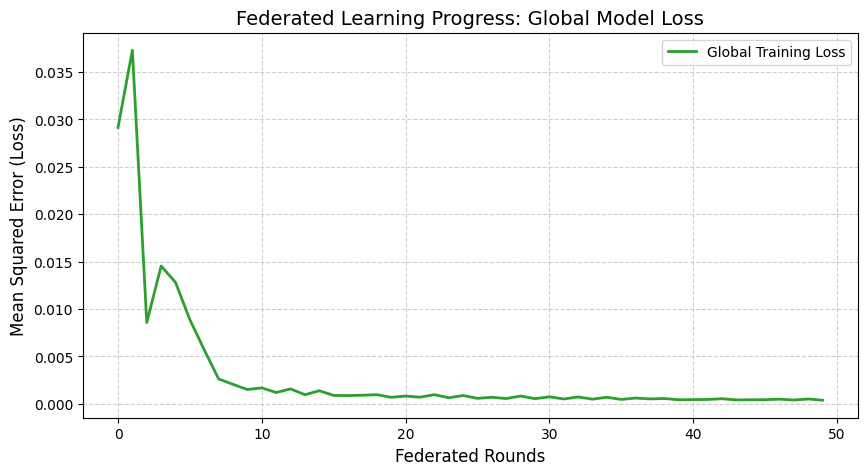

In [13]:
plt.figure(figsize=(10, 5))

# Plotting the loss
plt.plot(history_loss, label='Global Training Loss', color='#2ca02c', linewidth=2)

# Adding titles and labels
plt.title('Federated Learning Progress: Global Model Loss', fontsize=14)
plt.xlabel('Federated Rounds', fontsize=12)
plt.ylabel('Mean Squared Error (Loss)', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

plt.show()

In [14]:
def calculate_accuracy(model, test_client):
    model.eval()
    with torch.no_grad():
        predictions = model(test_client.X.to(device)).cpu().numpy()
        actuals = test_client.y.numpy() #cpu()

        # Calculate Percentage Error
        # We avoid division by zero by adding a tiny number (1e-5)
        mape = np.mean(np.abs((actuals - predictions) / (actuals + 1e-5))) * 100
        accuracy = 100 - mape
        
        print(f"Final Model Accuracy on Unseen Data: {accuracy:.2f}%")
        return accuracy

In [15]:
test_client = StockClient('my_stocks/Indian Hotels.csv')

In [16]:
calculate_accuracy(global_server_model, test_client)

Final Model Accuracy on Unseen Data: 93.93%


93.92893016338348